# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
cust_info = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
print("sample of Azidas data")
azdias.head()

sample of Azidas data


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Description of Azidas data")
azdias.describe()

Description of Azidas data


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:

print("We have the following info for Azidas data: " + str(azdias.shape[0]) + " rows/entries and " + str(azdias.shape[1]) + " features" )

We have the following info for Azidas data: 891221 rows/entries and 85 features


In [6]:
"Sample of mail order customer info data"
cust_info.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [7]:
print("description of mail order customer data")
cust_info.describe()

description of mail order customer data


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [8]:

print("We have the following for mail order demographic data: " + str(cust_info.shape[0]) + " rows/entries and " + str(cust_info.shape[1]) + " features" )

We have the following for mail order demographic data: 191652 rows/entries and 85 features


In [9]:
print("first rows of feature information data")
feat_info.head()

first rows of feature information data


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
print("description of feature information data")
feat_info.describe()

description of feature information data


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [11]:
print("full feature info data")
feat_info

full feature info data


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the **data dictionary** that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
#determine number of missing values for each feature in AZIDAS dataset
azdias_missing_data = azdias.isnull().sum()

In [13]:
#Missing data in azdias dataset
print("Missing info for Azidas data")
azdias_missing_data

Missing info for Azidas data


AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [14]:
#Replacing meaningless entries with NaN
for attribute, miss_list in zip(feat_info['attribute'], feat_info['missing_or_unknown']):

    miss_list = miss_list.strip('[]').split(',')
    
    for value in miss_list: 

        try:
            value = int(value)
        except:
            continue
        azdias.loc[azdias[attribute] == value, attribute] = np.nan


In [15]:
azdias.shape

(891221, 85)

In [16]:
print("Sample of updated data set")
azdias.head()

Sample of updated data set


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_count = azdias.isna().sum()
print(nan_count)


AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64


This histogram shows us the distribution of missing values. But it's impossible to get any meaningful information


<AxesSubplot:>

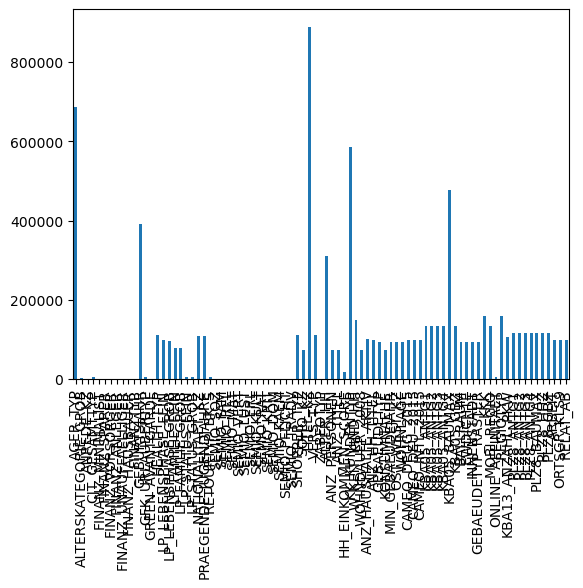

In [19]:
print("This histogram shows us the distribution of missing values. But it's impossible to get any meaningful information")
num_missing = azdias.apply(lambda x: x.isnull().value_counts()).T[True]



num_missing.hist()
num_missing.plot(kind = 'bar')

In [20]:
num_missing = pd.Series(num_missing, name = "Number_missing_values")
num_missing.fillna(0, inplace = True)

In [21]:
#the proportion of missing values might provide more insight

total_rows = azdias.shape[0]
pct_missing = (num_missing/total_rows) * 100
pct_missing = pd.Series(pct_missing, name = "Percentage_missing_values")


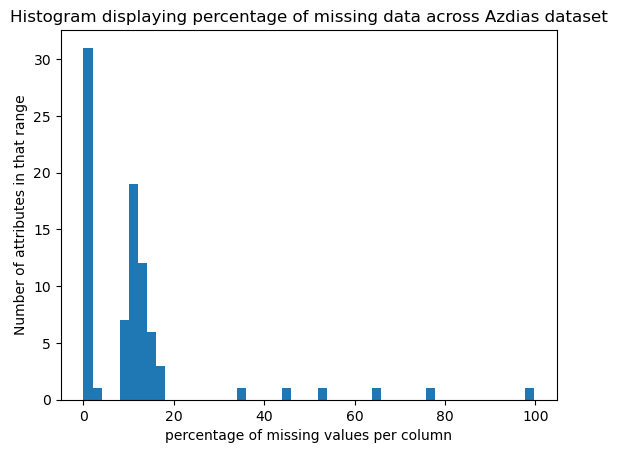

In [22]:
#Histogram of missing data

plt.hist(pct_missing, bins = 50)
plt.xlabel('percentage of missing values per column')
plt.ylabel('Number of attributes in that range')
plt.title('Histogram displaying percentage of missing data across Azdias dataset')
plt.show()

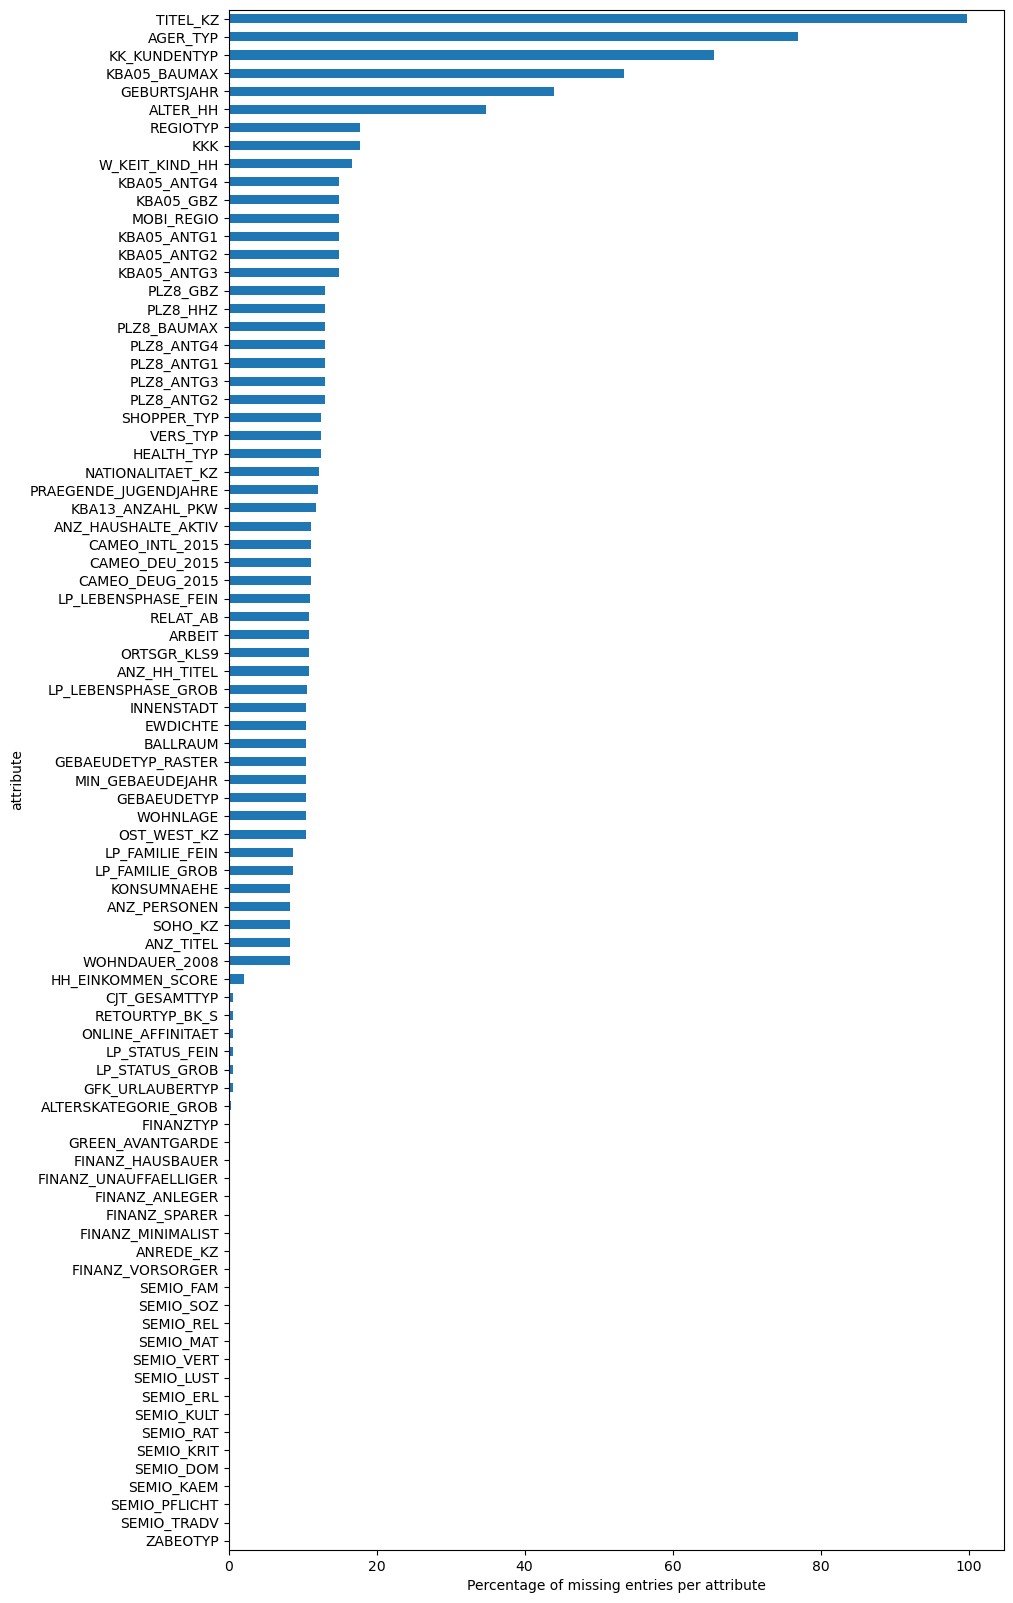

In [23]:
#Display each column by Percentage of missing values
pct_missing.sort_values(ascending = True, inplace = True)
pct_missing.plot.barh(figsize=(10,20))
plt.xlabel('Percentage of missing entries per attribute')
plt.ylabel('attribute')
plt.show()


In [24]:
miss_vals = pd.concat([num_missing, pct_missing], axis=1)
miss_vals['Number_missing_values'] == 0

AGER_TYP                False
ALTERSKATEGORIE_GROB    False
ANREDE_KZ                True
CJT_GESAMTTYP           False
FINANZ_MINIMALIST        True
                        ...  
PLZ8_HHZ                False
PLZ8_GBZ                False
ARBEIT                  False
ORTSGR_KLS9             False
RELAT_AB                False
Name: Number_missing_values, Length: 85, dtype: bool

In [25]:
#Out of 85 attributes only 5 have more than 40% of values missing. Therefore we will delete these 5 attributes

outliers = miss_vals[miss_vals['Percentage_missing_values'] > 40]

outliers




,Number_missing_values,Percentage_missing_values
AGER_TYP,685843.0,76.955435
GEBURTSJAHR,392318.0,44.020282
TITEL_KZ,889061.0,99.757636
KK_KUNDENTYP,584612.0,65.596749
KBA05_BAUMAX,476524.0,53.468668


In [26]:
azdias_clean = azdias.drop(outliers.index, axis = 1)
print("Outliers removed from dataset")

Outliers removed from dataset


In [27]:
# Remove outlier features from Feature Info Dataset
feat_info_update = feat_info.set_index("attribute")
for i, j in outliers.iterrows(): 
    feat_info_update.drop(i, axis=0, inplace = True) 

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The following columns were removed from the dataset:

AGER_TYP -  Person-level feature: Best-ager typology (76% of data missing)
GEBURTSJAHR	- Person-level feature: Birthday (44% of data missing)
TITEL_KZ - Person-level feature: Title(99% of data missing)
KK_KUNDENTYP: Household-level feature: Consumer pattern(65% of data missing)
KBA05_BAUMAX RR3 micro-cell features: Most common building type within the microcell(53% of data missing)

They represent a very small amount of total data across the Azdias data set (around 3%). Some characteristics (AGER_TYP, TITEL_KZ, KBA05_BAUMAX) are quite specific and on face value may be less relevant for what we are trying to do.

However, Birthday and Consumer pattern would be very useful features to have.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# Add a column to sum the number of NaN values per row
azdias_clean['count_NaN'] = azdias_clean.isnull().sum(axis=1)


In [29]:
azdias_clean['count_NaN']

0         44
1          1
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     1
891220     1
Name: count_NaN, Length: 891221, dtype: int64

In [30]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,count_NaN
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [31]:
azdias_clean['count_NaN'].describe()

count    891221.000000
mean          5.996775
std          13.425677
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: count_NaN, dtype: float64

This show the distribution of rows based on the number of NaN values in each row


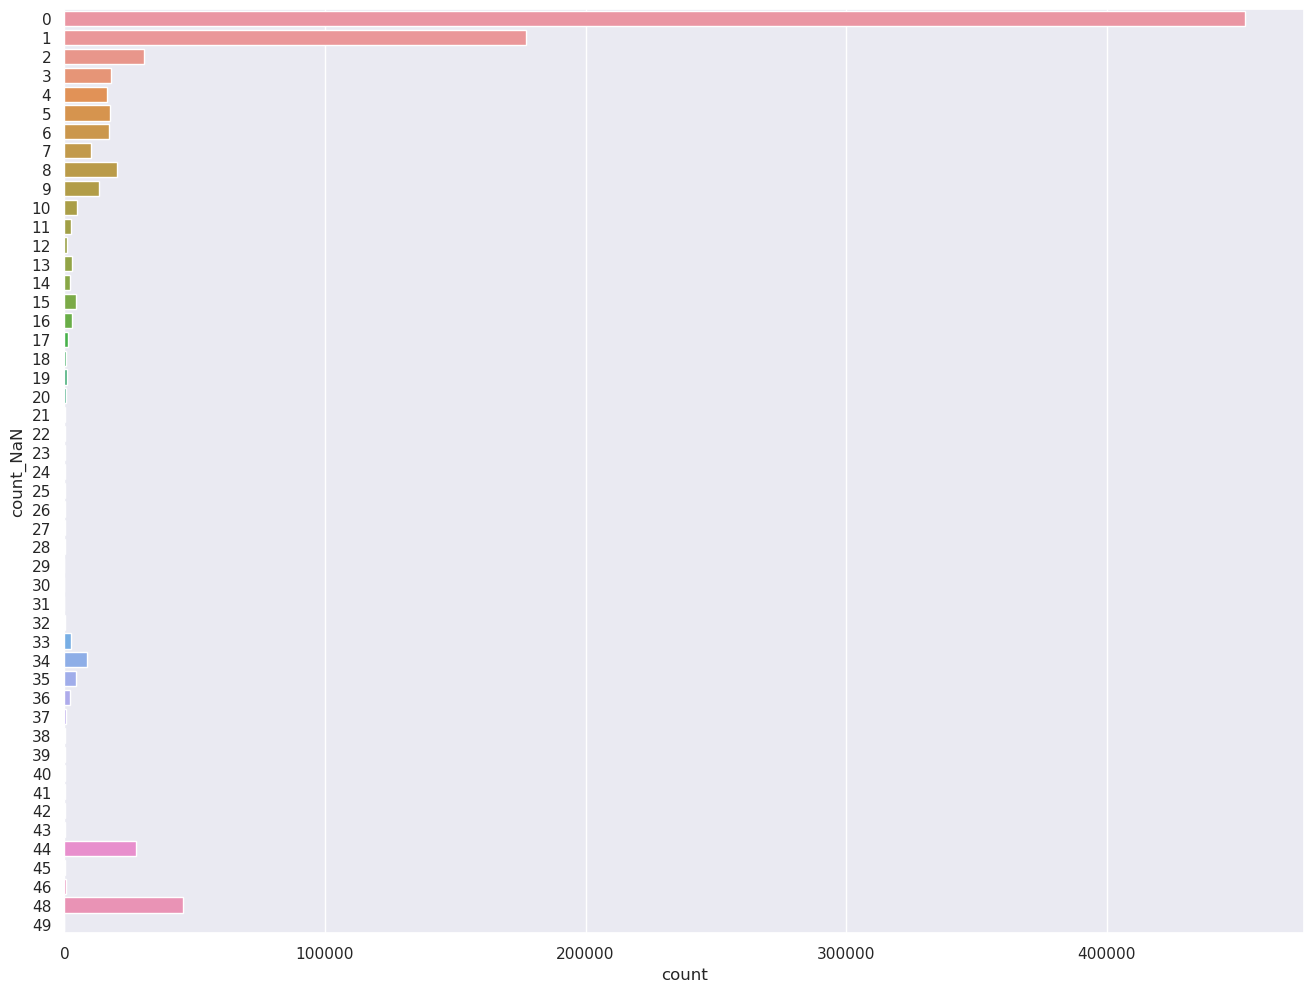

In [32]:
# Distribution of NaN values
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,12)})

sns.countplot(y=azdias_clean['count_NaN'])
print("This show the distribution of rows based on the number of NaN values in each row")

In [33]:
print("Based on this distribtion we will set outlier threshold for Count_NaN as 21")

Based on this distribtion we will set outlier threshold for Count_NaN as 21


In [34]:
# Dividing data into to subsets
primary_data = azdias_clean[azdias_clean['count_NaN'] <= 21]
outlier_data = azdias_clean[azdias_clean['count_NaN'] > 21]


Split of data based on number of rows without data


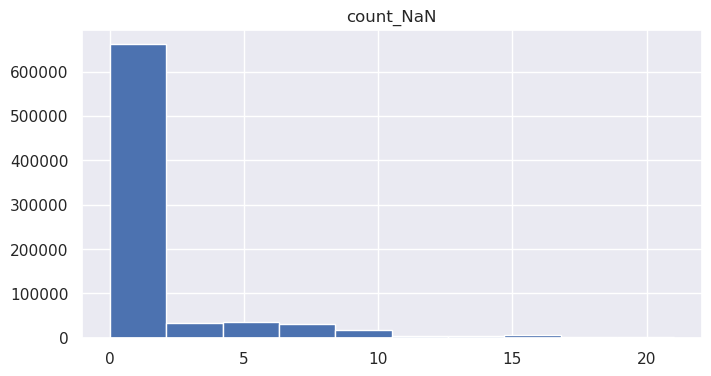

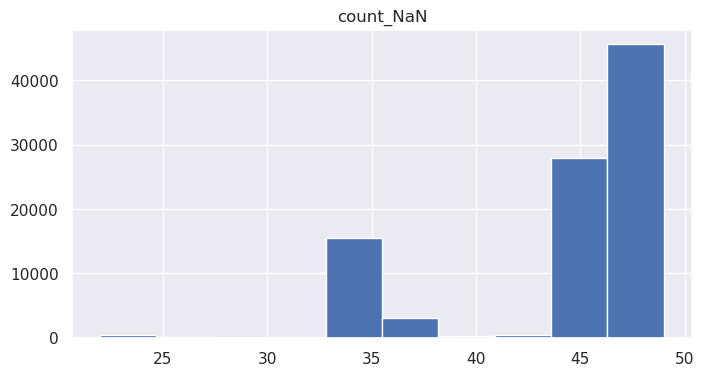

In [35]:
#Display split
sns.set(rc={'figure.figsize':(8,4)})
clean_row = pd.DataFrame(primary_data.isnull().sum(axis = 1), columns = ['count_NaN'])
missing_row = pd.DataFrame(outlier_data.isnull().sum(axis = 1), columns = ['count_NaN'])
clean_row.hist()
missing_row.hist()

print("Split of data based on number of rows without data")


In [36]:
zero_columns = miss_vals[miss_vals['Number_missing_values'] == 0]
zero_columns = zero_columns['Number_missing_values']
zero_columns

ANREDE_KZ                0.0
FINANZ_MINIMALIST        0.0
FINANZ_SPARER            0.0
FINANZ_VORSORGER         0.0
FINANZ_ANLEGER           0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_HAUSBAUER         0.0
FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
SEMIO_SOZ                0.0
SEMIO_FAM                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
Name: Number_missing_values, dtype: float64

In [37]:
comparison_columns = zero_columns[:5]

In [38]:
comparison_columns

ANREDE_KZ            0.0
FINANZ_MINIMALIST    0.0
FINANZ_SPARER        0.0
FINANZ_VORSORGER     0.0
FINANZ_ANLEGER       0.0
Name: Number_missing_values, dtype: float64

In [39]:
#Comparison function

def compare_split(data_1, data_2, column): 
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax[0].set_title('less than 21 missing values group')
    sns.countplot(data_1[column], ax=ax[0])
    ax[1].set_title('more than 21 missing values group')
    sns.countplot(data_2[column], ax=ax[1])
    plt.show()

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


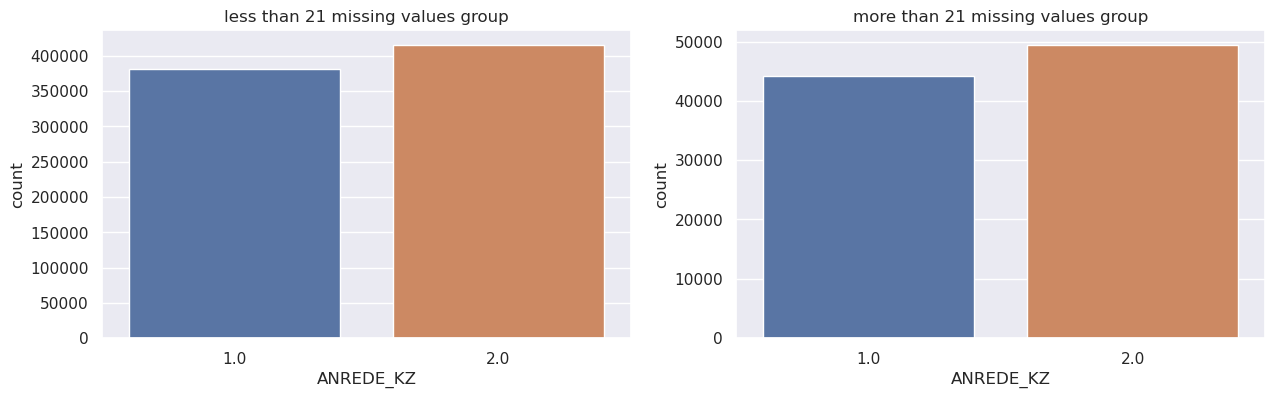

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


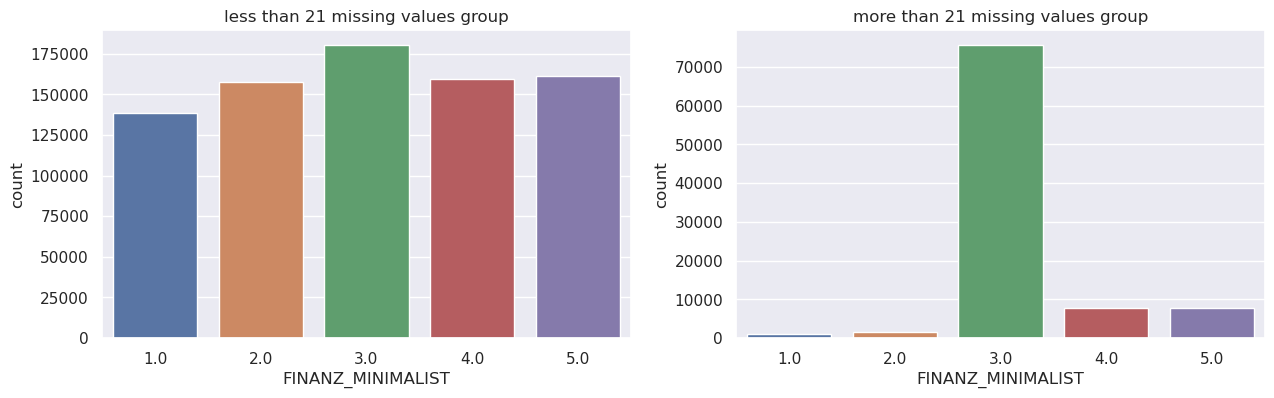

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


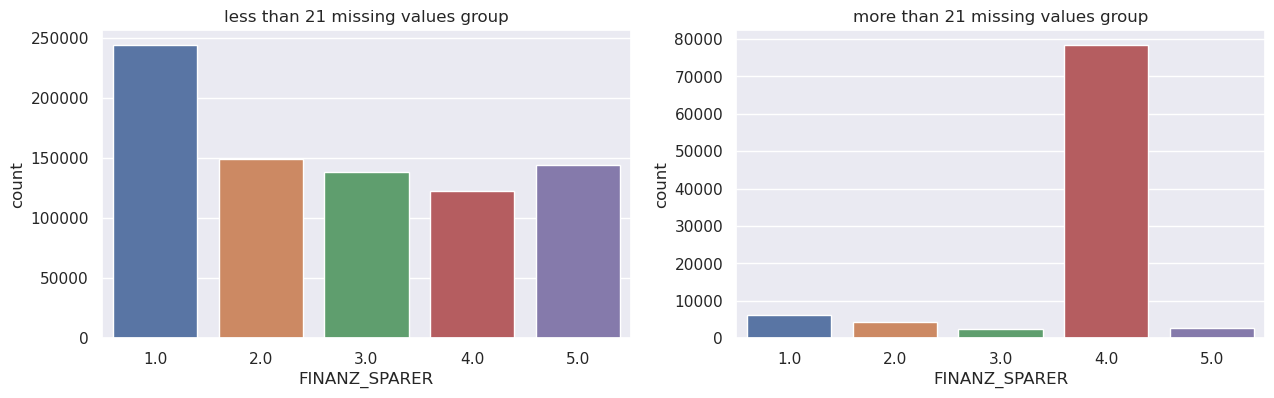

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


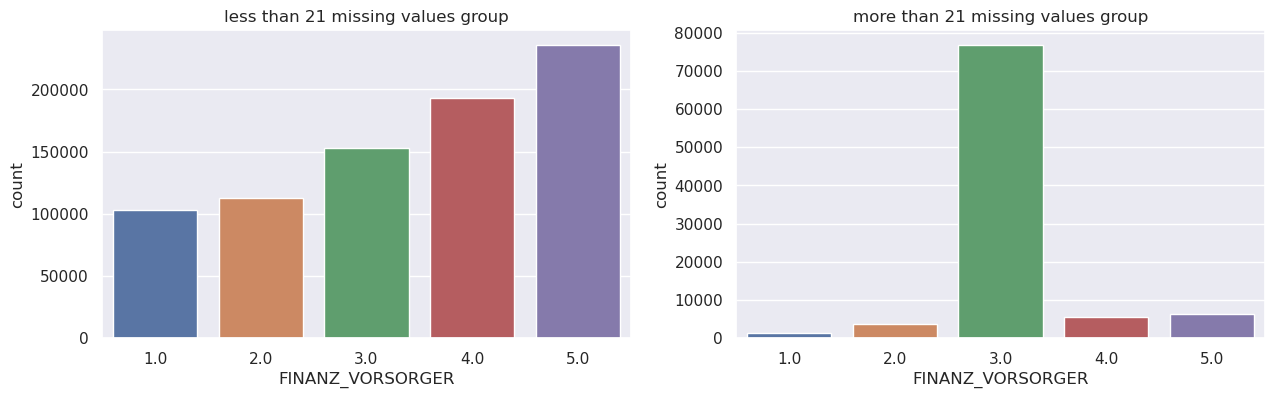

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


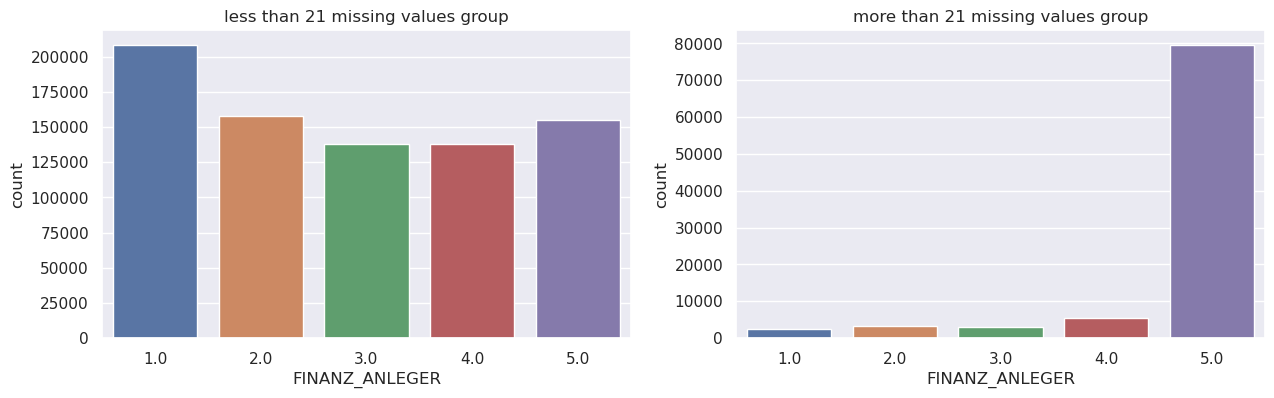

In [40]:

for i, j in comparison_columns.items(): 
    compare_split(primary_data, outlier_data, i) 


#### Discussion 1.1.3: Assess Missing Data in Each Row

As shown above the vast majority of the rows have less than 10 missing values. When considering the distribution of rows with respect to total number of missing entries, a clear split between those
with less than 21 missing values and those with more than 21 missing values. Thus, I split the data into these sub-sets accordingly.

When the comparing the results of these two subsets across features where there was no missing data a strong, systematic difference in results can be observed. 

Based on this only data from rows with less than 21 missing values will be used.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
# How many features are there of each data type?
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [42]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [43]:
#data type count
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

Orginally there were 21 Categorical varibles. However after cleaning the data only the following 18 remain.

Based on the Data Dictionary I would make the following assesment about the categorical variables:

ANREDE_KZ: Gender - binary with number as input, no action required
CAMEO_DEUG_2015 : multi-level categorical
CAMEO_DEU_2015 : multi-level categorical
CJT_GESAMTTYP : multi-level categorical
FINANZTYP : multi-level categorical
GEBAEUDETYP : multi-level categorical
GFK_URLAUBERTYP  multi-level categorical
GREEN_AVANTGARDE :binary with number as input, no action required
LP_FAMILIE_FEIN: multi-level categorical
LP_FAMILIE_GROB multi-level categorical
LP_STATUS_FEIN multi-level categorical
LP_STATUS_GROB multi-level categorical
NATIONALITAET_KZ multi-level categorical
OST_WEST_KZ: binary NON numeric
SHOPPER_TYP:multi-level categorical
SOHO_KZ:  binary with number as input, no action required
VERS_TYP:  binary with number as input, no action required
ZABEOTYP multi-level categorical

All multi-level categorical will be dropped from analysis
OST_WEST_KZ: binary NON numeric - will be re-encoded




In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_var = feat_info[feat_info['type'] == 'categorical']

cat_var = cat_var.drop("missing_or_unknown", axis = 1)
cat_var

,attribute,information_level,type
0,AGER_TYP,person,categorical
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
10,FINANZTYP,person,categorical
12,GFK_URLAUBERTYP,person,categorical
13,GREEN_AVANTGARDE,person,categorical
17,LP_FAMILIE_FEIN,person,categorical
18,LP_FAMILIE_GROB,person,categorical
19,LP_STATUS_FEIN,person,categorical
20,LP_STATUS_GROB,person,categorical


In [45]:
""" Varibles to be kept:
ANREDE_KZ: Gender - binary with number as input, no action required
GREEN_AVANTGARDE :binary with number as input, no action required
OST_WEST_KZ: binary NON numeric
SOHO_KZ:  binary with number as input, no action required
VERS_TYP:  binary with number as input, no action required

Varibles to be dropped:

CAMEO_DEUG_2015 : multi-level categorical
CAMEO_DEU_2015 : multi-level categorical
CJT_GESAMTTYP : multi-level categorical
xFINANZTYP : multi-level categorical
xGEBAEUDETYP : multi-level categorical
xGFK_URLAUBERTYP  multi-level categorical

LP_FAMILIE_FEIN: multi-level categorical
LP_FAMILIE_GROB multi-level categorical
LP_STATUS_FEIN multi-level categorical
LP_STATUS_GROB multi-level categorical
NATIONALITAET_KZ multi-level categorical

SHOPPER_TYP:multi-level categorical

ZABEOTYP multi-level categorical

"""

' Varibles to be kept:\nANREDE_KZ: Gender - binary with number as input, no action required\nGREEN_AVANTGARDE :binary with number as input, no action required\nOST_WEST_KZ: binary NON numeric\nSOHO_KZ:  binary with number as input, no action required\nVERS_TYP:  binary with number as input, no action required\n\nVaribles to be dropped:\n\nCAMEO_DEUG_2015 : multi-level categorical\nCAMEO_DEU_2015 : multi-level categorical\nCJT_GESAMTTYP : multi-level categorical\nxFINANZTYP : multi-level categorical\nxGEBAEUDETYP : multi-level categorical\nxGFK_URLAUBERTYP  multi-level categorical\n\nLP_FAMILIE_FEIN: multi-level categorical\nLP_FAMILIE_GROB multi-level categorical\nLP_STATUS_FEIN multi-level categorical\nLP_STATUS_GROB multi-level categorical\nNATIONALITAET_KZ multi-level categorical\n\nSHOPPER_TYP:multi-level categorical\n\nZABEOTYP multi-level categorical\n\n'

In [46]:
#drop multilevel categorical varibles
primary_data_minus_mlcat = primary_data.drop(columns = ["CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CJT_GESAMTTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP"])

In [47]:
#Recode binary non-numeric to binary numeric

primary_data_minus_mlcat["OST_WEST_KZ"] = primary_data_minus_mlcat["OST_WEST_KZ"].replace(['O', 'W'],[0,1])

#### Discussion 1.2.1: Re-Encode Categorical Features

***Varibles kept***:
ANREDE_KZ: Gender - binary with number as input, no action required
GREEN_AVANTGARDE :binary with number as input, no action required
OST_WEST_KZ: binary NON numeric **re-encoded** O = 0, W = 1
SOHO_KZ:  binary with number as input, no action required
VERS_TYP:  binary with number as input, no action required

***Varibles dropped***:
CAMEO_DEUG_2015 : multi-level categorical
CAMEO_DEU_2015 : multi-level categorical
CJT_GESAMTTYP : multi-level categorical
xFINANZTYP : multi-level categorical
xGEBAEUDETYP : multi-level categorical
xGFK_URLAUBERTYP  multi-level categorical
LP_FAMILIE_FEIN: multi-level categorical
LP_FAMILIE_GROB multi-level categorical
LP_STATUS_FEIN multi-level categorical
LP_STATUS_GROB multi-level categorical
NATIONALITAET_KZ multi-level categorical
SHOPPER_TYP:multi-level categorical
ZABEOTYP multi-level categorical

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
cat_mixed = feat_info[feat_info['type'] == 'mixed']
cat_mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
"""
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Two varibles:
interval: "Decade"

binary: "Movement"

Reencode to library


"""

'\n-  1: 40s - war years (Mainstream, E+W)\n-  2: 40s - reconstruction years (Avantgarde, E+W)\n-  3: 50s - economic miracle (Mainstream, E+W)\n-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)\n-  5: 60s - economic miracle (Mainstream, E+W)\n-  6: 60s - generation 68 / student protestors (Avantgarde, W)\n-  7: 60s - opponents to the building of the Wall (Avantgarde, E)\n-  8: 70s - family orientation (Mainstream, E+W)\n-  9: 70s - peace movement (Avantgarde, E+W)\n- 10: 80s - Generation Golf (Mainstream, W)\n- 11: 80s - ecological awareness (Avantgarde, W)\n- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)\n- 13: 80s - Swords into ploughshares (Avantgarde, E)\n- 14: 90s - digital media kids (Mainstream, E+W)\n- 15: 90s - ecological awareness (Avantgarde, E+W)\n\nTwo varibles:\ninterval: "Decade"\n\nbinary: "Movement"\n\nReencode to library\n\n\n'

In [50]:
generation_dict =   {
                    1: 40.0,
                    2: 40.0,
                    3: 50.0,
                    4: 50.0,
                    5: 60.0,
                    6: 60.0,
                    7: 60.0,
                    8: 70.0,
                    9: 70.0,
                    10: 80.0,
                    11: 80.0,
                    12: 80.0,
                    13: 80.0,
                    14: 90.0, 
                    15: 90.0
                    }

movement_dict =     {
                    1: 0.0,
                    2: 1.0,
                    3: 0.0,
                    4: 1.0,
                    5: 0.0,
                    6: 1.0,
                    7: 1.0,
                    8: 0.0,
                    9: 1.0,
                    10: 0.0,
                    11: 1.0,
                    12: 0.0,
                    13: 1.0,
                    14: 0.0, 
                    15: 1.0,
                    }

In [51]:

primary_data_minus_mlcat["DECADE"] = primary_data_minus_mlcat.PRAEGENDE_JUGENDJAHRE
primary_data_minus_mlcat["MOVEMENT"] = primary_data_minus_mlcat.PRAEGENDE_JUGENDJAHRE

In [52]:
primary_data_minus_mlcat["DECADE"].replace(generation_dict, inplace=True)
primary_data_minus_mlcat["MOVEMENT"].replace(movement_dict, inplace=True)

In [53]:
primary_data_minus_mlcat.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)


In [54]:
primary_data_minus_mlcat["DECADE"].value_counts()
primary_data_minus_mlcat["MOVEMENT"].value_counts()

0.0    593856
1.0    175173
Name: MOVEMENT, dtype: int64

In [55]:
wealth_dict =       {
                    '11': 1.0,
                    '12': 1.0,
                    '13': 1.0,
                    '14': 1.0,
                    '15': 1.0,
                    '21': 2.0,
                    '22': 2.0,
                    '23': 2.0,
                    '24': 2.0,
                    '25': 2.0,
                    '31': 3.0,
                    '32': 3.0,
                    '33': 3.0,
                    '34': 3.0, 
                    '35': 3.0,
                    '41': 4.0,
                    '42': 4.0,
                    '43': 4.0,
                    '44': 4.0, 
                    '45': 4.0,
                    '51': 5.0,
                    '52': 5.0,
                    '53': 5.0,
                    '54': 5.0, 
                    '55': 5.0                                                                                                                                        
                    }

lifestage_dict =    {
                    '11': 1.0,
                    '12': 2.0,
                    '13': 3.0,
                    '14': 4.0,
                    '15': 5.0,
                    '21': 1.0,
                    '22': 2.0,
                    '23': 3.0,
                    '24': 4.0,
                    '25': 5.0,
                    '31': 1.0,
                    '32': 2.0,
                    '33': 3.0,
                    '34': 4.0, 
                    '35': 5.0,
                    '41': 1.0,
                    '42': 2.0,
                    '43': 3.0,
                    '44': 4.0, 
                    '45': 5.0,
                    '51': 1.0,
                    '52': 2.0,
                    '53': 3.0,
                    '54': 4.0, 
                    '55': 5.0
                    }

In [56]:
primary_data_minus_mlcat["WEALTH"] = primary_data_minus_mlcat.CAMEO_INTL_2015
primary_data_minus_mlcat["STAGE"] = primary_data_minus_mlcat.CAMEO_INTL_2015

In [57]:
primary_data_minus_mlcat["WEALTH"].replace(wealth_dict, inplace=True)
primary_data_minus_mlcat["STAGE"].replace(lifestage_dict, inplace=True)

In [58]:
primary_data_minus_mlcat["WEALTH"]

1         5.0
2         2.0
3         1.0
4         4.0
5         5.0
         ... 
891216    4.0
891217    5.0
891218    2.0
891219    5.0
891220    4.0
Name: WEALTH, Length: 797504, dtype: object

In [59]:
primary_data_minus_mlcat.drop("CAMEO_INTL_2015", axis=1, inplace=True)

In [60]:
primary_data_minus_mlcat = primary_data_minus_mlcat.drop(columns = ["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "WOHNLAGE","PLZ8_BAUMAX"])


#### Discussion 1.2.2: Engineer Mixed-Type Features

The two mixed varibles highlighted, CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE, contained a significant amount of information that will enchance the dataset. For example, we had to remove GEBURTSJAHR, but "DECADE" (from PRAEGENDE_JUGENDJAHRE) and "STAGE" (from CAMEO_INTL_2015) capture aspects of a persons age that would otherwise have been lost as we had to drop GEBURTSJAHR. The other data from these variables are also very relavent aspects when classifing customers (Wealth and lifestage).

For simplicity the rest of the mixed variables were dropped.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [61]:
azdias_data_revised = primary_data_minus_mlcat

In [62]:
azdias_data_revised["STAGE"]

1         1.0
2         4.0
3         2.0
4         3.0
5         4.0
         ... 
891216    1.0
891217    1.0
891218    4.0
891219    1.0
891220    3.0
Name: STAGE, Length: 797504, dtype: object

In [63]:
azdias_data_revised["WEALTH"]

1         5.0
2         2.0
3         1.0
4         4.0
5         5.0
         ... 
891216    4.0
891217    5.0
891218    2.0
891219    5.0
891220    4.0
Name: WEALTH, Length: 797504, dtype: object

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [64]:
def clea_nan(df, mapper, mapper_column_name, mapper_column_definition, non_numerical_indicators=[]):
    # For each mapper_df row definition
    for index, row in mapper.iterrows():
        
        # Omit rows with no NaNs or with lists without values
        if len(row[mapper_column_definition]) > 0 and row[mapper_column_definition] != ['']:
            try:
                # For each column definition build a list of nan_indicators
                replace_mask = []
                for nan_indicator in row[mapper_column_definition]:
                    
                    if nan_indicator in non_numerical_indicators:
                        replace_mask.append(nan_indicator)
                    else:
                        replace_mask.append(int(nan_indicator))
                
                # Replace masked values with NaN
                df[row[mapper_column_name]] = df[row[mapper_column_name]].replace(replace_mask, np.nan)
                
            except Exception as e:
                print('Exception: {} -> {} --> {}'.format(row[mapper_column_name], str(e), nan_indicator))
                continue
                
    return df

In [65]:
def clean_data(df, df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
       
    if missing_or_unknown != ['']:
        df_clean = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df = df_clean.replace({col: ['XX', 'X']}, np.nan)
    
    #STEP 2 preprocessing - columns
    
    #STEP 2A get number of missing values for each column
    
    num_missing = df.apply(lambda x: x.isnull().value_counts()).T[True]
    num_missing = pd.Series(num_missing, name = "Number_missing_values")
    num_missing.fillna(0, inplace = True)
    
    #print(num_missing)
    
    #STEP 2B get proportion of missing values for each column
    
    total_rows = df.shape[0]
    pct_missing = (num_missing/total_rows) * 100
    pct_missing = pd.Series(pct_missing, name = "Percentage_missing_values")
    
    #print(pct_missing)
    
    #STEP 2C combine above into dataframe
    
    miss_vals = pd.concat([num_missing, pct_missing], axis=1)
    
    #print(miss_vals)

    #STEP 2D split off outliers (those with 40% or more of missing values)
    
    outliers = miss_vals[miss_vals['Percentage_missing_values'] > 40]
    #print(outliers)
    df_clean = df.drop(outliers.index, axis = 1)
    #print(df_clean)
    #print("Outliers removed from dataset")
    
    # STEP 2E Remove outlier features from Feature Info Dataset
    
    feat_info_update = df_feat.set_index("attribute")
    for i, j in outliers.iterrows(): 
        feat_info_update.drop(i, axis=0, inplace = True) 
    
    #print(feat_info_update)
    
    
    #STEP 3 preprocessing - rows
    
    #STEP 3A add column to sum the number of NaN values per row
    df_clean['count_NaN'] = df_clean.isnull().sum(axis=1)
    
    #STEP 3B Divide rows into subsets based on number of empty values
    #In this case 21 missing values per row was selected as the threshold
    primary_data = df_clean[df_clean['count_NaN'] <= 21]
    outlier_data = df_clean[df_clean['count_NaN'] > 21]
    
    #print(primary_data)
    
    #STEP 4 select, re-encode, and engineer column values.
    
    primary_data_minus_mlcat = primary_data
    
    #STEP 4A Remove Categorical Features
    try:
        primary_data_minus_mlcat = primary_data.drop(columns = ["CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CJT_GESAMTTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP"])
    except:
        print("Columns removed")
    
    #STEP 4B Recode binary non-numeric variable to binary numeric
    primary_data_minus_mlcat["OST_WEST_KZ"] = primary_data_minus_mlcat["OST_WEST_KZ"].replace(['O', 'W'],[0,1])

    #STEP 4C Recode mixed variables
    
    #STEP 4Ci Recode "PRAEGENDE_JUGENDJAHRE" variable
    generation_dict =   {
                    1: 40.0,
                    2: 40.0,
                    3: 50.0,
                    4: 50.0,
                    5: 60.0,
                    6: 60.0,
                    7: 60.0,
                    8: 70.0,
                    9: 70.0,
                    10: 80.0,
                    11: 80.0,
                    12: 80.0,
                    13: 80.0,
                    14: 90.0, 
                    15: 90.0
                    }
    movement_dict =     {
                    1: 0.0,
                    2: 1.0,
                    3: 0.0,
                    4: 1.0,
                    5: 0.0,
                    6: 1.0,
                    7: 1.0,
                    8: 0.0,
                    9: 1.0,
                    10: 0.0,
                    11: 1.0,
                    12: 0.0,
                    13: 1.0,
                    14: 0.0, 
                    15: 1.0,
                    }
    
    try:
        primary_data_minus_mlcat["DECADE"] = primary_data_minus_mlcat.PRAEGENDE_JUGENDJAHRE
        primary_data_minus_mlcat["MOVEMENT"] = primary_data_minus_mlcat.PRAEGENDE_JUGENDJAHRE
        
    except:
        print("2nd Clean Phase 4Ci")
            
        
    
    primary_data_minus_mlcat["DECADE"].replace(generation_dict, inplace=True)
    primary_data_minus_mlcat["MOVEMENT"].replace(movement_dict, inplace=True)
    
    #print(primary_data_minus_mlcat["DECADE"])
    #print(primary_data_minus_mlcat["MOVEMENT"])
    
    try:
        primary_data_minus_mlcat.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)
    except:
        print("2nd Clean Phase 4Cii")
    
    #STEP 4Cii Recode ""CAMEO_INTL_2015" variable
    
    wealth_dict =       {
                    '11': 1.0,
                    '12': 1.0,
                    '13': 1.0,
                    '14': 1.0,
                    '15': 1.0,
                    '21': 2.0,
                    '22': 2.0,
                    '23': 2.0,
                    '24': 2.0,
                    '25': 2.0,
                    '31': 3.0,
                    '32': 3.0,
                    '33': 3.0,
                    '34': 3.0, 
                    '35': 3.0,
                    '41': 4.0,
                    '42': 4.0,
                    '43': 4.0,
                    '44': 4.0, 
                    '45': 4.0,
                    '51': 5.0,
                    '52': 5.0,
                    '53': 5.0,
                    '54': 5.0, 
                    '55': 5.0                                                                                                                                        
                    }
    lifestage_dict =    {
                    '11': 1.0,
                    '12': 2.0,
                    '13': 3.0,
                    '14': 4.0,
                    '15': 5.0,
                    '21': 1.0,
                    '22': 2.0,
                    '23': 3.0,
                    '24': 4.0,
                    '25': 5.0,
                    '31': 1.0,
                    '32': 2.0,
                    '33': 3.0,
                    '34': 4.0, 
                    '35': 5.0,
                    '41': 1.0,
                    '42': 2.0,
                    '43': 3.0,
                    '44': 4.0, 
                    '45': 5.0,
                    '51': 1.0,
                    '52': 2.0,
                    '53': 3.0,
                    '54': 4.0, 
                    '55': 5.0
                    }
    
    
    primary_data_minus_mlcat["WEALTH"] = df_clean['CAMEO_INTL_2015']
    primary_data_minus_mlcat["STAGE"] = df_clean['CAMEO_INTL_2015']
        


    primary_data_minus_mlcat["WEALTH"].replace(wealth_dict, inplace=True)
    primary_data_minus_mlcat["STAGE"].replace(lifestage_dict, inplace=True)
    

    primary_data_minus_mlcat.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    


    
    primary_data_minus_mlcat["WEALTH"].fillna(np.nan, inplace = True)
    primary_data_minus_mlcat["STAGE"].fillna(np.nan, inplace = True)
    
    #STEP 4Ciii remove remaining mixed variables
    

    primary_data_minus_mlcat = primary_data_minus_mlcat.drop(columns = ["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "WOHNLAGE","PLZ8_BAUMAX"])
        

        
        
    
    df = primary_data_minus_mlcat
    
    # Return the cleaned dataframe.
    
    return df
    

In [66]:
azdias2 = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
feat_info2 = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
feat_info2

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [67]:
azdias = clean_data(azdias2, feat_info2)

In [68]:
azdias= azdias.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [69]:
print(azdias.isna().sum())


AGER_TYP                0
ALTERSKATEGORIE_GROB    0
ANREDE_KZ               0
FINANZ_MINIMALIST       0
FINANZ_SPARER           0
                       ..
count_NaN               0
DECADE                  0
MOVEMENT                0
WEALTH                  0
STAGE                   0
Length: 70, dtype: int64


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias = azdias.fillna(method="ffill")

print(azdias.isna().sum())





AGER_TYP                0
ALTERSKATEGORIE_GROB    0
ANREDE_KZ               0
FINANZ_MINIMALIST       0
FINANZ_SPARER           0
                       ..
count_NaN               0
DECADE                  0
MOVEMENT                0
WEALTH                  0
STAGE                   0
Length: 70, dtype: int64


In [71]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

cols = azdias.columns
sc = StandardScaler()
azdias_scaled = pd.DataFrame(sc.fit_transform(azdias), columns=cols)








In [72]:
azdias_scaled_clean = azdias_scaled.fillna(method="ffill")

### Discussion 2.1: Apply Feature Scaling

The only issues I had to overcome here were:
ensuring that all of my data was numeric :(azdias= azdias.apply(lambda x: pd.to_numeric(x, errors='coerce') 
keeping the column labels when scaling

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(random_state=42)
pca_data = pca.fit_transform(azdias_scaled_clean)


In [74]:
# Investigate the variance accounted for by each principal component. [ADAPTED FROM LESSON]
def pca_results(full_dataset, pca):


# Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

# PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    return pd.concat([variance_ratios, components], axis = 1)

In [75]:
pca_results(azdias_scaled_clean, pca)

,Explained Variance,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,count_NaN,DECADE,MOVEMENT,WEALTH,STAGE
Dimension 1,0.1624,-0.0649,-0.0949,0.0106,-0.2106,0.1311,-0.1004,0.0572,0.0641,0.1634,...,0.0404,-0.1705,0.1440,0.1978,0.1344,-0.0,0.0418,-0.1130,0.2082,-0.1245
Dimension 2,0.1250,0.1640,0.2524,0.0897,0.0808,-0.2430,0.2406,-0.2062,-0.2278,0.1066,...,0.0096,-0.0581,0.0542,0.0731,0.0522,-0.0,-0.2116,-0.0087,0.0562,0.0095
Dimension 3,0.0877,0.0833,0.0715,-0.3693,0.1602,-0.1078,0.1015,-0.1903,-0.0993,-0.0493,...,0.0040,-0.0378,0.0332,0.0458,0.0299,0.0,-0.0598,0.0513,0.0242,-0.0077
Dimension 4,0.0485,0.0060,-0.0403,0.0378,0.0794,-0.0163,-0.0171,-0.1288,0.0635,-0.1248,...,0.1097,-0.0022,0.0746,0.2610,0.1068,-0.0,0.0956,0.3882,-0.1186,0.0522
Dimension 5,0.0366,-0.0293,0.0069,0.0131,-0.0782,0.0285,0.0421,-0.0253,0.0952,0.0813,...,0.4003,0.3283,-0.1779,-0.0359,-0.1082,-0.0,-0.1935,0.0400,-0.0449,0.0053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 66,0.0012,0.0102,0.0710,0.0776,-0.4300,-0.7230,-0.3242,0.2164,-0.0657,-0.1583,...,0.0085,-0.0187,0.0350,-0.0147,-0.0167,0.0,-0.0306,-0.0015,0.0132,-0.0116
Dimension 67,0.0011,0.0064,0.0179,0.0174,-0.1294,-0.0721,-0.0069,-0.0015,-0.0174,-0.0578,...,0.0016,-0.0000,0.0050,-0.0098,-0.0071,0.0,-0.0020,-0.0034,-0.0104,-0.0043
Dimension 68,0.0009,-0.0026,-0.1498,-0.8296,-0.0897,-0.1554,-0.0401,0.0537,0.0067,0.0252,...,0.0171,-0.0010,-0.0069,0.0318,-0.0002,0.0,0.0278,0.0136,0.0042,0.0008
Dimension 69,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,...,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0,-0.0000,-0.7071,-0.0000,0.0000


In [76]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(15):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12, rotation=90)
 
    ax.xaxis.set_tick_params(width=16, rotation = 45)
    ax.yaxis.set_tick_params(width=16, length=50)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

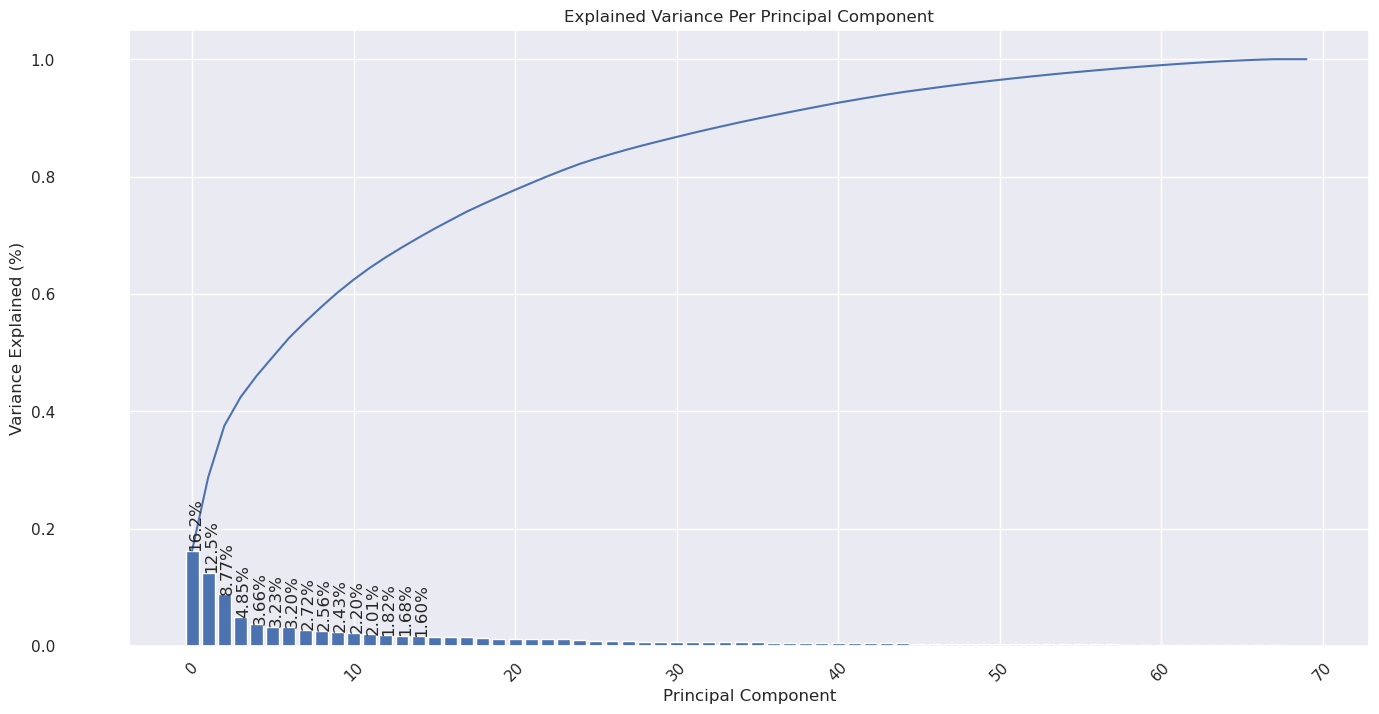

In [77]:
scree_plot(pca)

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.
#The top 30 components explain a significant amount of the variance. There are significant diminishing returns in adding further components


pca_data = pca.fit_transform(azdias_scaled_clean)
X = azdias_scaled_clean
pca30=PCA(n_components=30, random_state=42)
pca30.fit(azdias_scaled_clean)

PCA(n_components=30, random_state=42)

In [79]:
X

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,count_NaN,DECADE,MOVEMENT,WEALTH,STAGE
0,-0.572287,-1.682267,0.956254,-1.466835,1.526679,-1.044670,1.466122,1.005857,1.306196,0.836378,...,1.428970,0.573271,-0.189875,-0.153563,0.665038,0.0,0.990838,-0.533797,1.157341,-1.247213
1,-0.572287,0.169436,0.956254,-1.466835,0.856558,-1.770674,-0.568593,0.285667,1.306196,0.818691,...,0.395011,0.573271,-0.189875,-0.153563,-0.810638,0.0,0.990838,1.873371,-0.888324,0.757733
2,-0.572287,0.169436,-1.045747,0.712590,0.186437,0.407338,-1.246831,0.285667,-0.869700,0.802044,...,-0.638948,-0.325210,0.818973,0.281936,1.402876,0.0,-0.039804,-0.533797,0.475453,0.089417
3,2.664945,-1.682267,0.956254,-0.013885,-1.153804,1.133342,-0.568593,-0.434522,1.306196,0.781235,...,1.428970,1.471752,-1.198722,-1.024561,-0.072800,0.0,-1.070445,-0.533797,1.157341,0.757733
4,-0.572287,-0.756416,0.956254,-1.466835,1.526679,-1.770674,1.466122,1.005857,-0.144401,-1.240334,...,1.428970,1.471752,0.818973,0.281936,-0.072800,0.0,0.475517,-0.533797,-0.888324,-0.578898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697532,-0.572287,-1.682267,0.956254,-1.466835,1.526679,-1.044670,0.109645,0.285667,0.580898,0.817650,...,1.428970,-1.223690,-0.189875,0.717435,-0.072800,0.0,0.990838,-0.533797,-0.888324,0.089417
697533,-0.572287,-0.756416,0.956254,-1.466835,1.526679,-1.044670,0.787883,1.726047,0.580898,-1.240334,...,0.395011,0.573271,-1.198722,-0.153563,-0.810638,0.0,0.475517,-0.533797,-0.206436,-1.247213
697534,-0.572287,-0.756416,-1.045747,-0.013885,0.186437,-0.318666,-0.568593,-0.434522,-0.144401,0.809327,...,1.428970,-0.325210,0.818973,0.281936,1.402876,0.0,0.475517,-0.533797,1.157341,-1.247213
697535,-0.572287,-1.682267,-1.045747,-1.466835,1.526679,-0.318666,1.466122,1.726047,1.306196,0.834297,...,-2.706867,-2.122171,0.818973,0.717435,1.402876,0.0,0.990838,-0.533797,1.157341,-1.247213


In [80]:
pca30

PCA(n_components=30, random_state=42)

In [81]:
pca_results(azdias_scaled_clean, pca30)

,Explained Variance,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,count_NaN,DECADE,MOVEMENT,WEALTH,STAGE
Dimension 1,0.1624,-0.0649,-0.0949,0.0106,-0.2106,0.1311,-0.1004,0.0572,0.0641,0.1634,...,0.0404,-0.1705,0.1440,0.1978,0.1344,-0.0,0.0418,-0.1130,0.2082,-0.1245
Dimension 2,0.1250,0.1640,0.2524,0.0897,0.0808,-0.2430,0.2406,-0.2062,-0.2278,0.1066,...,0.0096,-0.0581,0.0542,0.0731,0.0522,-0.0,-0.2116,-0.0087,0.0562,0.0095
Dimension 3,0.0877,0.0833,0.0715,-0.3693,0.1602,-0.1078,0.1015,-0.1903,-0.0993,-0.0493,...,0.0040,-0.0378,0.0332,0.0458,0.0299,0.0,-0.0598,0.0513,0.0242,-0.0077
Dimension 4,0.0485,0.0060,-0.0403,0.0378,0.0794,-0.0163,-0.0171,-0.1288,0.0635,-0.1248,...,0.1097,-0.0022,0.0746,0.2610,0.1068,0.0,0.0956,0.3882,-0.1186,0.0522
Dimension 5,0.0366,-0.0293,0.0069,0.0131,-0.0782,0.0285,0.0421,-0.0253,0.0952,0.0813,...,0.4003,0.3283,-0.1779,-0.0359,-0.1082,0.0,-0.1934,0.0400,-0.0449,0.0053
Dimension 6,0.0323,-0.0187,0.0020,0.0089,-0.0194,0.0029,-0.0397,0.0364,-0.0466,0.0172,...,-0.0241,-0.0727,-0.1497,-0.0967,-0.1960,-0.0,0.0266,-0.0164,-0.0709,0.0387
Dimension 7,0.0321,-0.0188,0.0280,0.0404,0.0095,0.0245,-0.0277,0.0405,0.0366,0.0297,...,-0.3328,-0.2475,0.0955,0.0534,0.0722,-0.0,-0.2523,0.0887,-0.0516,0.0517
Dimension 8,0.0273,0.0505,0.1181,-0.0070,-0.0027,0.0418,0.0137,0.0586,0.0417,-0.0337,...,0.1472,0.0787,-0.0534,0.0275,-0.0261,-0.0,-0.0509,-0.0181,0.0546,-0.0572
Dimension 9,0.0257,-0.0989,-0.0891,-0.0063,0.0551,0.0044,0.0338,-0.0205,0.0567,-0.1306,...,-0.0152,0.0336,-0.0597,0.1063,0.0020,-0.0,0.0240,0.0472,-0.0405,0.0113
Dimension 10,0.0244,0.0032,0.0277,-0.0064,-0.0254,0.0191,-0.0106,0.0402,0.0083,0.0253,...,0.0038,0.0100,0.0108,-0.0404,0.0225,-0.0,0.0290,-0.0060,0.0472,-0.0137


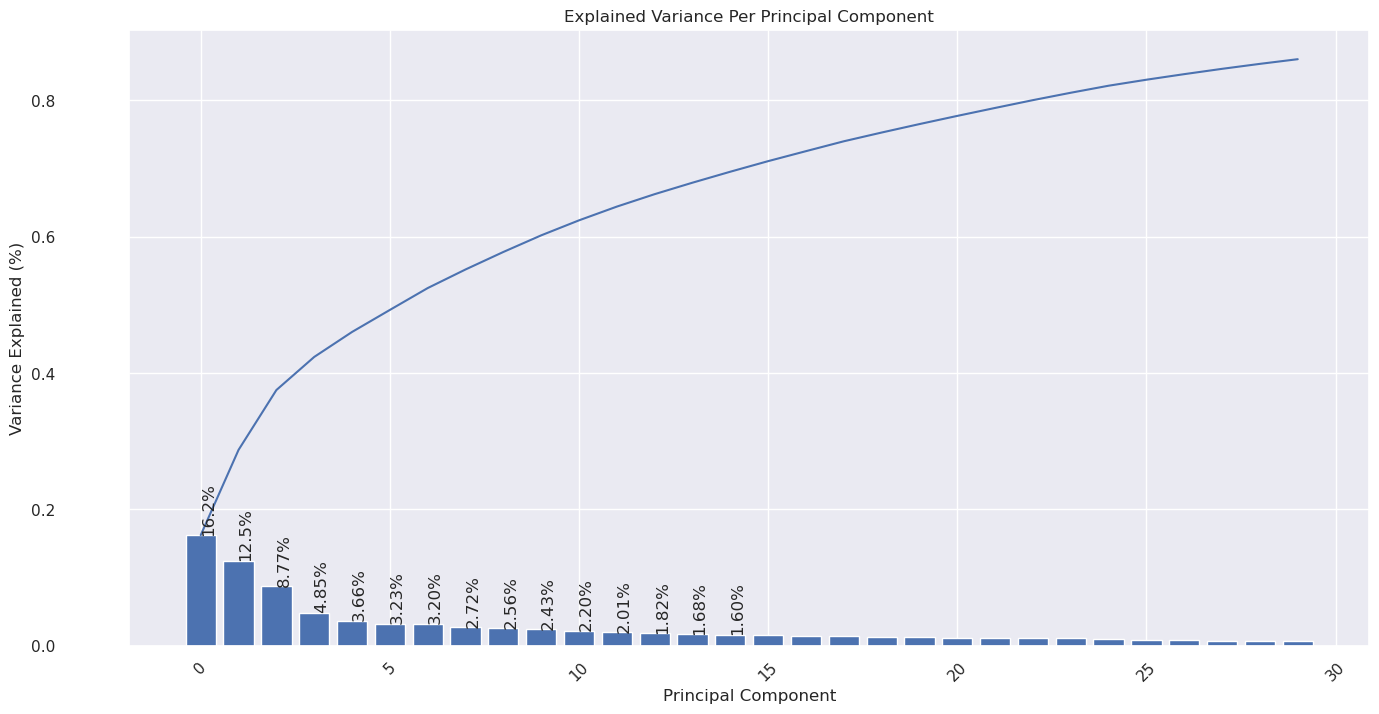

In [82]:
scree_plot(pca30)

### Discussion 2.2: Perform Dimensionality Reduction

From the literature I have read the total variance explained by all components should be at least 70% in this type of analysis. To meet this threshold 15 principal components are required. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# Top 10 feature weights for the the Nth priciple component
def plot_weights_vis(pca, n):

    p_weight = pd.DataFrame(pca.components_, columns = azdias_scaled_clean.keys())
    
    weights=p_weight.iloc[n,:].sort_values(ascending=False, key=abs)[:10]
    map_series=weights>0
    
    weights.plot(kind='barh',color=map_series.map({True: 'g', False: 'r'}))

    plt.show()

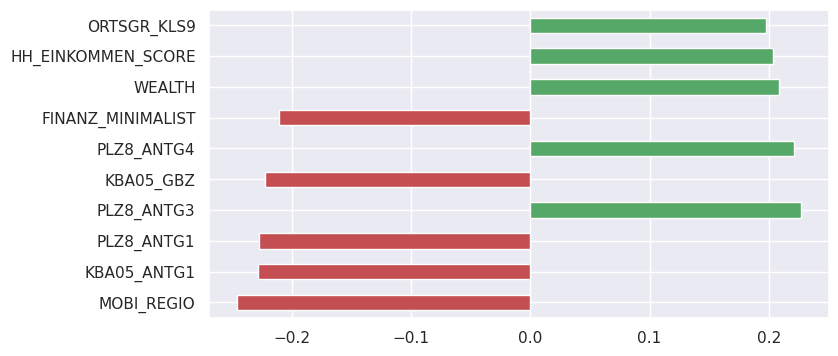

In [84]:
#Top 10 weights for the first priciple component
plot_weights_vis(pca30, 0)

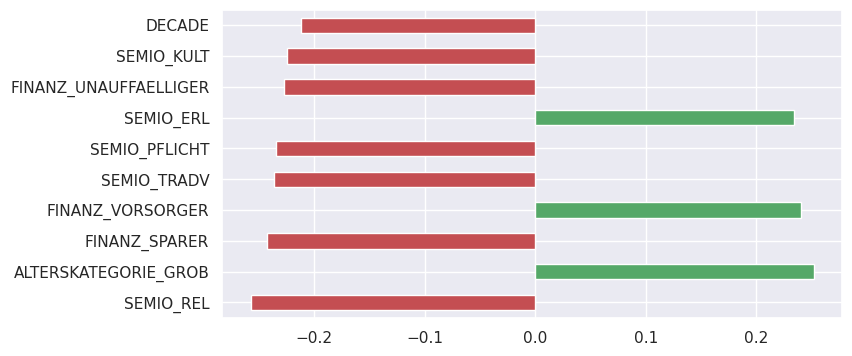

In [85]:
#Top 10 weights for the second priciple component
plot_weights_vis(pca30, 1)

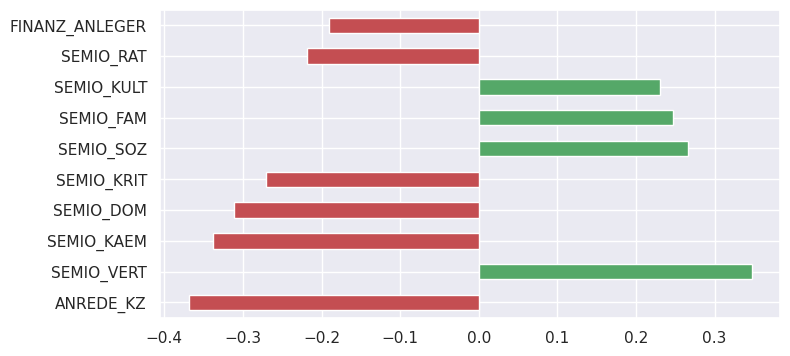

In [86]:
#Top 10 weights for the third priciple component
plot_weights_vis(pca30, 2)

### Discussion 2.3: Interpret Principal Components

- First Principle Component:
This was primarly positivitly affected by living situation (PLAZ_ANTG3 & PLAZ_ANTG4) Wealth and Net income. Upon closer examination these factors are either proxies for, or directly related to the Socio-Economic status of the given customer. This would be expected as those with greater economic means would likley make purchases more frequently and may be less price sensitive to the additional costs associated with mail order (i.e. shipping costs.

- Second Principle Component:

This was primarly positivitly affected by Age (ALTERSKATEGORIE_GROB), how cautious the invidiual is when it comes to financial decisions (FINANZ_VORSORGER) and are most constrained (restrained?) (SEMIO_ERL). These would suggest that older persons, who are cautious when it comes to buying decisions and more financially restrained (i.e. prudent/frugal) are more likley to make mail order purchases.

- Third Principle Component:

This was primarly positivitly affected by the personality charaterisitcs of SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM. Without further insight into the data, collection techniques or market context I cannot make any further inferences.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
#new data

azdias_km= azdias_scaled_clean.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
print(azdias.isna().sum())

AGER_TYP                0
ALTERSKATEGORIE_GROB    0
ANREDE_KZ               0
FINANZ_MINIMALIST       0
FINANZ_SPARER           0
                       ..
count_NaN               0
DECADE                  0
MOVEMENT                0
WEALTH                  0
STAGE                   0
Length: 70, dtype: int64


In [88]:
from sklearn.cluster import KMeans

In [89]:
azidas_pca = pca30.transform(X)

In [90]:
print(azidas_pca.shape)

(697537, 30)


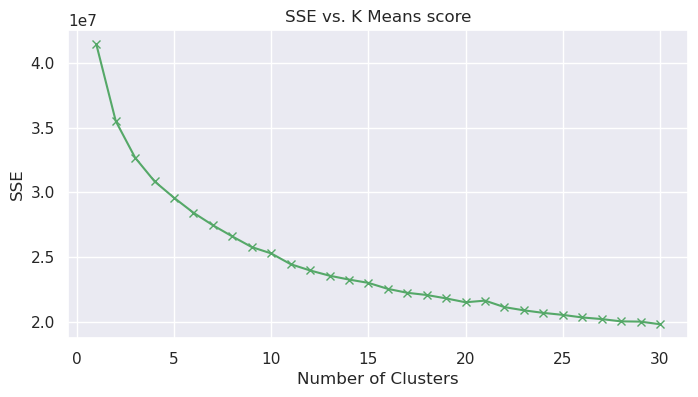

In [91]:
def get_kmeans(dataset, km_value):


    kmeans = KMeans(n_clusters=km_value)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(dataset)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(dataset))
    
    return score

scores = []
km_values = list(range(1,31))

for km_value in km_values:
    scores.append(get_kmeans(azidas_pca, km_value))
    
plt.plot(km_values, scores, linestyle='-', marker='x', color='g');
plt.xlabel('Number of Clusters');
plt.ylabel('SSE');
plt.title('SSE vs. K Means score');

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num, random_state=42)
kmeans_10 = kmeans.fit(azidas_pca)

pop_cluster = kmeans_10.predict(azidas_pca)


/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


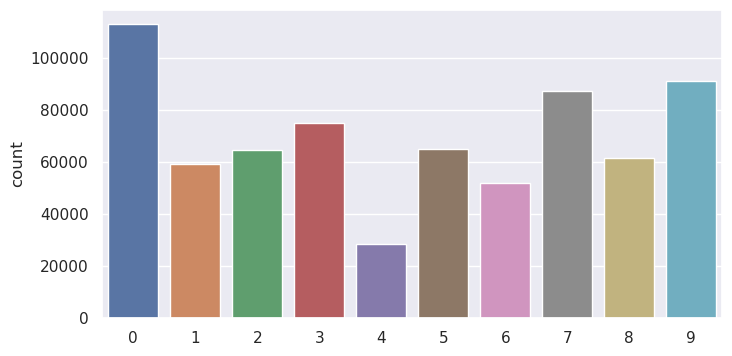

In [93]:
sns.countplot(pd.Series(pop_cluster))
plt.show()

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [94]:
# Load in the customer demographics data and summarise
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
display(customers.head())
display(customers.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [95]:
#Clean customer data
customer_clean = clean_data(customers, feat_info)

In [96]:
customer_clean.isnull().sum()

AGER_TYP                  0
ALTERSKATEGORIE_GROB      0
ANREDE_KZ                 0
FINANZ_MINIMALIST         0
FINANZ_SPARER             0
                       ... 
count_NaN                 0
DECADE                    0
MOVEMENT                  0
WEALTH                  492
STAGE                   492
Length: 70, dtype: int64

In [97]:
customer_clean = customer_clean.fillna(method="ffill")
customer_clean= customer_clean.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()



In [98]:

customer_clean.isna().sum()

AGER_TYP                0
ALTERSKATEGORIE_GROB    0
ANREDE_KZ               0
FINANZ_MINIMALIST       0
FINANZ_SPARER           0
                       ..
count_NaN               0
DECADE                  0
MOVEMENT                0
WEALTH                  0
STAGE                   0
Length: 70, dtype: int64

In [99]:
#Obs about customer data

In [100]:
# Apply preprocessing
#Standardising values between -1 and 1
#customers_std=scaler.transform(customers_cleaned)
customer_scaled = sc.transform(customer_clean)

print('Dataset shape of standardised values of customer dataset between -1 and 1', customer_scaled.shape)

# Reduce dimensionality to 30

customer_pca = pca30.fit_transform(customer_scaled)

print('Dataset shape of standardised values of customer dataset between -1 and 1, reduced to 30 principle components', customer_pca.shape)

Dataset shape of standardised values of customer dataset between -1 and 1 (141573, 70)
Dataset shape of standardised values of customer dataset between -1 and 1, reduced to 30 principle components (141573, 30)


In [101]:
# obtaining cluster predictions for the customer demographics data.

customer_km = kmeans_10.predict(customer_pca)
customer_km_df = pd.DataFrame(customer_km)

In [102]:
customer_km.shape

(141573,)

/home/ubtadobres/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


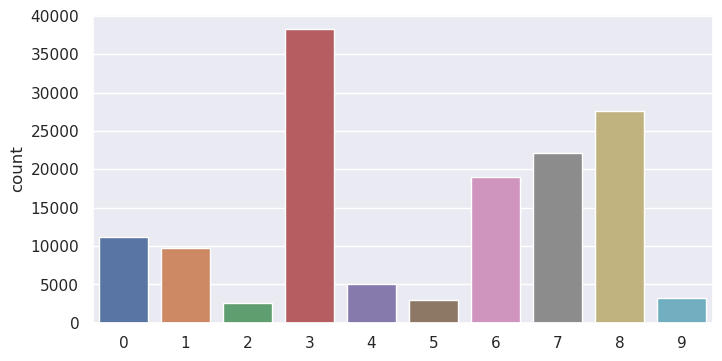

In [103]:
# bar chart of weights of top 10 customer priciple components
sns.countplot(pd.Series(customer_km, ))
plt.show()


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [104]:
pop_cluster_df = pd.DataFrame(pop_cluster)
customer_km_df = pd.DataFrame(customer_km)

In [105]:
pop_total = azdias.shape[0]
cust_total = customers.shape[0]

In [106]:
pop_pca_perc = list(pop_cluster_df[0].value_counts()/pop_total)
cust_pca_perc = list(customer_km_df[0].value_counts()/cust_total)

In [107]:
cust_pca_perc

[0.19948656940705028,
 0.14371882370129194,
 0.11557927911005364,
 0.09886147809571515,
 0.05841316552918832,
 0.050643875357418655,
 0.026104606265522926,
 0.016743889967232275,
 0.01558032266816939,
 0.013566255504769061]

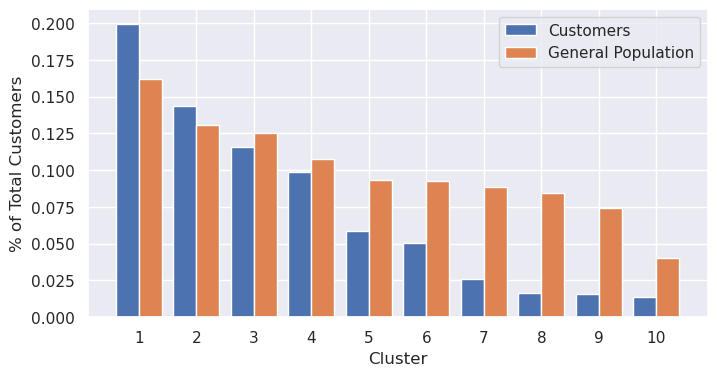

In [108]:
x_axis = np.arange(len(cust_pca_perc)) + 1
plt.bar(x_axis-0.2, cust_pca_perc, label='Customers', width=0.4)
plt.bar(x_axis+0.2,pop_pca_perc, label='General Population', width=0.4)

plt.xlabel('Cluster')
plt.ylabel('% of Total Customers')
plt.xticks(x_axis)
plt.legend()
plt.show()

In the customer base ***Cluster 1*** is overepresented compared to the general population

In the General population ***Clusters 5,6,7,8,9*** are overepresented compared to the customer base

In [109]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
customer_pca.shape


(141573, 30)

In [110]:
cluster0_centers = kmeans_10.cluster_centers_[0]
cluster9_centers = kmeans_10.cluster_centers_[8]

In [111]:
top_5_pcs_clus0 = pd.Series(cluster0_centers).sort_values(ascending=False)
top_5_pcs_clus0.head()

2     2.266216
8     0.165104
1     0.112626
12    0.104486
19    0.082975
dtype: float64

In [112]:
top_5_pcs_clus0.shape

(30,)

In [113]:
top_5_pcs_clus9 = pd.Series(cluster9_centers).sort_values(ascending=False)
top_5_pcs_clus9.head()

2     1.764100
25    0.156151
27    0.144549
22    0.132080
16    0.124463
dtype: float64

In [115]:
clus0_orig_vals = sc.inverse_transform(pca30.inverse_transform(top_5_pcs_clus0))
clus0_orig_vals = pd.Series(clus0_orig_vals)
clus0_orig_vals.index = customers_cleaned.columns
print(clus0_orig_vals.to_string())

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.86084217  0.50653798 -0.34854169  1.09125194 -0.82016569  0.80468605
 -0.71625601 -0.35490368 -0.91752385  0.09332441  0.55578502  0.16012564
  0.68285122  1.54033025 -0.84850754 -0.31591015  0.31422895  0.46089849
 -0.18803523 -1.29983789 -0.28959564 -1.11231686  0.73342458 -0.05599658
 -0.69146761 -0.60540239 -1.65554311  0.01317679 -0.01314056 -0.55622173
  0.1913869   0.58574941  0.15279813 -1.2580021  -0.39217763  0.30708204
 -0.12233675 -0.13274538  1.10775337  1.24551853  0.66031943  0.18936753
  0.10369782 -0.5578927  -0.22243819 -0.98251328  0.68266047  0.22040183
 -0.31927125  0.46689824 -0.39230115 -0.12932403  0.56982248  0.16918738
 -0.16335203  0.36262896  0.51236784 -0.73344258 -0.44959909  0.01890684
  0.03760627  0.24237554 -0.72810454 -0.37007762 -0.04044366  2.51707052
 -0.52486003  0.55578502 -0.58061756  0.26821297].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
clus0_orig_vals = ss.inverse_transform(pca_103.inverse_transform(top_5_pcs_clus0))
clus0_orig_vals = pd.Series(clus0_orig_vals)
clus0_orig_vals.index = customers_cleaned.columns
print(clus0_orig_vals.to_string())

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.